In [15]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import pynwb
import graph
import glob
import os
from pathlib import Path 
import warnings

from sklearn.cluster import KMeans
from numpy import linalg as LA
import statsmodels.api as sm
from scipy.stats import nbinom
from scipy import stats
from scipy import optimize
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
from scipy.stats import ttest_rel
from scipy.stats import norm
from scipy.stats import f
from scipy.stats import chi2
from scipy import signal
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
import matplotlib
from sklearn.metrics import confusion_matrix
import matplotlib.gridspec as gridspec
import joblib
import pickle
from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def get_FR_df(nwbfile, region, epoch, query="", window=[500,800], unit_params = {"drift": 2, "min_fr": 1}):
    
    """_summary_

    Returns:
        (np.array, pd.DataFrame) : spike table aligned to the specified epoch, dataframe with step metadata
        
    """
    assert epoch in nwbfile.intervals.keys(), f"Epoch {epoch} not found in nwbfile intervals. Available epochs: {nwbfile.intervals.keys()}"
    
    assert region in ["HPC", "OFC"], f"Region {region} not found. Available regions: ['HPC', 'OFC']"

    
    unitNames = nwbfile.units.to_dataframe()
    unit_idx = np.where((unitNames.region == region) & (unitNames.group == "good") & \
                        (unitNames.drift <= unit_params["drift"]) & (unitNames.fr >= unit_params["min_fr"]))[0]
    unitNames = unitNames.iloc[unit_idx, :].reset_index(drop=True)

    
    # subsample an epoch with a specific query
    if query == "":
        df = nwbfile.intervals[epoch].to_dataframe()#["timeseries"]
    else:
        df = nwbfile.intervals[epoch].to_dataframe().query(query)#["timeseries"]

    neural_timeseries_index = 0
        
    sample_index = df.index
    FR = np.zeros((len(sample_index), len(unit_idx)), dtype=np.float32)
    normFR = np.zeros((len(sample_index), len(unit_idx)), dtype=np.float32)

    for i, _sample in tqdm(enumerate(sample_index)):
        sample_data = df["timeseries"][_sample][neural_timeseries_index].data[:, unit_idx]
        FR[i, :] = sample_data[window[0]:window[1]].mean(axis=0)*1000
    
    for nn in tqdm(range(FR.shape[1])):          
        y = FR[:,nn]
        if y.sum()>0:
            normFR[:,nn] = (y - np.mean(y)) / np.sqrt(np.var(y))
    
    df = df.drop(columns=["timeseries"])
    df['FR'] = list(FR)
    df['normFR'] = list(normFR)
    
    df = graph.append_use_tele(df)
    
    return df, unitNames

In [5]:
def combine_df(region,epoch,query,animal):
    
    # combine all sessions
    if animal=='London':
        DATA_DIR = Path('/Volumes/Extreme SSD/teleworld/london/neural')
    if animal=='Bart':
        DATA_DIR = Path('/Volumes/Extreme SSD')
    
    os.chdir(DATA_DIR)
    filenames = glob.glob('*.nwb') # sorted()
        
    df = pd.DataFrame()
    neuron_df = pd.DataFrame()
    
    for ii, filename in enumerate(filenames):

        print(filename)
        if animal=='London':
            date = filename[-17:-11] 
        if animal=='Bart':
            date = filename[-10:-4]
        
        nwbfile = pynwb.NWBHDF5IO(filename, "r").read()
        temp_df, unitNames = get_FR_df(nwbfile, region, epoch, query = query)

        temp_df.insert(0,'Session',date)
        df = pd.concat([df,temp_df]).reset_index(drop=True)
    
        unitNames.insert(0,'Session',date)
        neuron_df = pd.concat([neuron_df,unitNames]).reset_index(drop=True)

    if epoch=='action_on':
        df['prenode'] = np.insert(df.node.values[:-1], 0, -1)
        df['postnode'] = np.insert(df.node.values[1:], -1, -1)
        df.loc[df.step==0,'prenode'] = -1
        df.loc[df.step==df.nsteps,'postnode'] = -1

    if epoch=='fixations':
        df['node']=df['fix_node']
        df['distance'] = df.apply(lambda row: graph.distance(row['fix_node'], row['target']), axis=1)    
        
    return df, neuron_df

In [9]:
sz1 = 12
sz2 = 12
sns.set(style="ticks", rc={"lines.linewidth": 1})
matplotlib.rc('xtick', labelsize=sz1) 
matplotlib.rc('ytick', labelsize=sz1) 
matplotlib.rc('axes', labelsize=sz1)  
matplotlib.rc('axes', titlesize=sz1)  
matplotlib.rc('figure', titlesize=sz2)
matplotlib.rc('legend', fontsize=sz1) 
matplotlib.rc('legend', title_fontsize=sz1)
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

colors16 = [
    "#1f77b4","#ff7f0e","#2ca02c","#d62728",
    "#9467bd","#8c564b","#e377c2","#7f7f7f",
    "#bcbd22","#17becf","#a55194","#393b79",
    "#637939","#8c6d31","#843c39","#cedb9c"
]

In [19]:
DATA_DIR = Path('/Volumes/Extreme SSD/teleworld/london/neural')
os.chdir(DATA_DIR)
filename = DATA_DIR/"London_TeleWorld_4x4_101124_spikes.nwb/"
nwbfile = pynwb.NWBHDF5IO(filename, "r").read() 

In [23]:
a = nwbfile.intervals['trials'].to_dataframe()["timeseries"]

In [27]:
a[0]

[TimeSeriesReference(idx_start=34858, count=2320, timeseries=neural pynwb.base.TimeSeries at 0x6272517472
 Fields:
   comments: no comments
   conversion: 1.0
   data: <HDF5 dataset "data": shape (5945246, 930), type "|b1">
   description: raw neural spiking data
   offset: 0.0
   rate: 1.0
   resolution: -1.0
   starting_time: 0.0
   starting_time_unit: seconds
   unit: ms
 ),
 TimeSeriesReference(idx_start=0, count=13, timeseries=events pynwb.base.TimeSeries at 0x6292109312
 Fields:
   comments: no comments
   conversion: 1.0
   data: <HDF5 dataset "data": shape (27711,), type "<f8">
   description: eventcodes
   interval: 1
   offset: 0.0
   resolution: -1.0
   timestamps: <HDF5 dataset "timestamps": shape (27711,), type "<f8">
   timestamps_unit: seconds
   unit: ms
 ),
 TimeSeriesReference(idx_start=0, count=2270, timeseries=eyes pynwb.base.TimeSeries at 0x6307479040
 Fields:
   comments: no comments
   conversion: 1.0
   data: <HDF5 dataset "data": shape (4425258, 2), type "<f8">

In [11]:
def get_spike_table(nwbfile, region, epoch, unitNumber=[], query="", window_size=0, 
                    unit_params = {"drift": 2, "min_fr": 1}, fix_spike='loose'):
    
    """_summary_

    Returns:
        (np.array, pd.DataFrame) : spike table aligned to the specified epoch, dataframe with step metadata
        
    """
    assert epoch in nwbfile.intervals.keys(), f"Epoch {epoch} not found in nwbfile intervals. Available epochs: {nwbfile.intervals.keys()}"
    
    assert region in ["HPC", "OFC"], f"Region {region} not found. Available regions: ['HPC', 'OFC']"

    
    unitNames = nwbfile.units.to_dataframe()
    
    if len(unitNumber)==0:
        # get all good units
        unit_idx = np.where((unitNames.region == region) & (unitNames.group == "good") & (unitNames.drift <= unit_params["drift"]) & (unitNames.fr >= unit_params["min_fr"]))[0]
    else:
        # get a specific unit
        unit_idx = np.where((unitNames.region == region) & (unitNames.group == "good") & (unitNames.drift <= unit_params["drift"]) 
                            & (unitNames.fr >= unit_params["min_fr"]) & (unitNames.unitNumber==unitNumber))[0]
        
    unitNames = unitNames.iloc[unit_idx, :].reset_index(drop=True)

    
    # subsample an epoch with a specific query
    if query == "":
        df = nwbfile.intervals[epoch].to_dataframe()#["timeseries"]
    else:
        df = nwbfile.intervals[epoch].to_dataframe().query(query)#["timeseries"]

    neural_timeseries_index = 0

    
    if epoch!='fixations':
        
        epoch_win_size = df["window_size"].values[0]
        sample_index = df.index
        spikes = np.zeros((len(sample_index), epoch_win_size*2, len(unit_idx)), dtype=np.float32)
        print("Building Spike Table")
        if window_size != 0:
            for i, _sample in tqdm(enumerate(sample_index)):
                sample_data = df["timeseries"][_sample][neural_timeseries_index].data[:, unit_idx]
                sample_data = movmean(sample_data.T, window_size).T
                spikes[i, ...] = sample_data.reshape(1, epoch_win_size*2, -1)
        else:
            for i, _sample in tqdm(enumerate(sample_index)):
                sample_data = df["timeseries"][_sample][neural_timeseries_index].data[:, unit_idx]
                spikes[i, ...] = sample_data.reshape(1, epoch_win_size*2, -1)
    

    if epoch=='fixations':

        if fix_spike=='loose':

            epoch_win_size = 500
            trial_df = nwbfile.trials.to_dataframe().query("trialerror == 0")
            df = df.query("duration >= 50")
            
            spikes = np.zeros((len(df), epoch_win_size*2, len(unit_idx)), dtype=np.float32)
            
            trial_index = trial_df.index
            fix_idx = 0
            
            for ii, trial in tqdm(enumerate(trial_index)):
                
                trial_spikes = trial_df.iloc[ii].timeseries[neural_timeseries_index]
                trial_start = trial_df.iloc[ii].start_time
            
                fixations_during_trial = df.query("trial == @ trial")
            
            
                for _, fix in fixations_during_trial.iterrows():
            
                    sample_data = np.ones((epoch_win_size*2, len(unit_idx)), dtype=np.float32)*np.nan
            
                    in_trial = np.isin(np.arange(fix.start_time - epoch_win_size,fix.start_time + epoch_win_size),trial_spikes.timestamps)
            
                    time_idx = (trial_spikes.timestamps >= fix.start_time - epoch_win_size) & (trial_spikes.timestamps < fix.start_time + epoch_win_size)
                    
                    sample_data[in_trial] = trial_spikes.data[time_idx, :][:, unit_idx]
                    spikes[fix_idx, ...] = sample_data.reshape(1, epoch_win_size*2, -1)
                    fix_idx = fix_idx + 1

        if fix_spike=='strict':
            
            epoch_win_size = 500
            df = df.query("duration >= 50")
            sample_index = df.index
            spikes = np.zeros((len(sample_index), epoch_win_size, len(unit_idx)), dtype=np.float32)
            print("Building Spike Table")
            
            for i, _sample in tqdm(enumerate([sample_index[0]])):
                sample_data = df["timeseries"][_sample][0].data[:,unit_idx]
                if sample_data.shape[0]>=epoch_win_size:
                    spikes[i, ...] = sample_data[:epoch_win_size,:].reshape(1, epoch_win_size, -1)
                else: 
                    spikes[i, ...] = np.concatenate([sample_data,
                                     np.nan*np.ones((epoch_win_size-sample_data.shape[0],sample_data.shape[1]))])
                    
        df['planning'] = (df.duration<300) & (df.active_prob<0.2)
        df['choice'] = (df.duration>300) & (df.active_prob>0.2)
    
    df = graph.append_use_tele(df)
    
    return spikes, df, unitNames

In [13]:
def combine_data(region,epoch,query,animal,fix_spike='loose'):
    
    # combine all sessions
    if animal=='London':
        DATA_DIR = Path('/Volumes/Extreme SSD/teleworld/london/neural')
    if animal=='Bart':
        DATA_DIR = Path('/Volumes/Extreme SSD')
    
    os.chdir(DATA_DIR)
    filenames = glob.glob('*.nwb') # sorted()
        
    df = pd.DataFrame()
    spikes = [[] for i in range(len(filenames))]
    neuron_df = pd.DataFrame()
    
    for ii, filename in enumerate(filenames):

        print(filename)
        if animal=='London':
            date = filename[-17:-11] 
        if animal=='Bart':
            date = filename[-10:-4]
        
        nwbfile = pynwb.NWBHDF5IO(filename, "r").read()
        temp_spikes, temp_df, unitNames = get_spike_table(nwbfile, region, epoch, query = query, window_size = 0, fix_spike = fix_spike)
        
        temp_df.insert(0,'Session',date)
        df = pd.concat([df,temp_df]).reset_index(drop=True)
        spikes[ii] = temp_spikes
    
        unitNames.insert(0,'Session',date)
        neuron_df = pd.concat([neuron_df,unitNames]).reset_index(drop=True)

    if epoch=='action_on':
        df['prenode'] = np.insert(df.node.values[:-1], 0, -1)
        df['postnode'] = np.insert(df.node.values[1:], -1, -1)
        df.loc[df.step==0,'prenode'] = -1
        df.loc[df.step==df.nsteps,'postnode'] = -1

    if epoch=='fixations':
        df['node']=df['fix_node']
        df['distance'] = df.apply(lambda row: graph.distance(row['fix_node'], row['target']), axis=1)    
        
    return df, spikes, neuron_df

In [1]:
filename = "/Volumes/Extreme SSD/Teleworld/london/neural/London_TeleWorld_4x4_100124_spikes.nwb"
nwbfile = pynwb.NWBHDF5IO(filename, "r").read() 

NameError: name 'pynwb' is not defined

In [35]:
nwbfile.intervals.keys()

dict_keys(['action_on', 'fixations', 'node_on', 'reward_on', 'trials'])

In [123]:
choice_df, neuron_df = combine_df("HPC","node_on","(trialerror < 2)",'London')
choice_df['istarget'] = choice_df['target']==choice_df['node']
choice_df['blocktrialnumber']=choice_df.groupby(['Session','block','trial']).cumcount()+1

Bart_TeleWorld_v13_031723.nwb


1727it [00:01, 1439.00it/s]
100%|████████████████████████████████████████| 80/80 [00:00<00:00, 16031.74it/s]


Bart_TeleWorld_v13_032823.nwb


2095it [00:01, 1273.54it/s]
100%|████████████████████████████████████████| 94/94 [00:00<00:00, 20668.09it/s]


Bart_TeleWorld_v13_033123.nwb


2319it [00:01, 1499.73it/s]
100%|████████████████████████████████████████| 88/88 [00:00<00:00, 19172.97it/s]


Bart_TeleWorld_v13_032023.nwb


2566it [00:01, 1514.79it/s]
100%|████████████████████████████████████████| 73/73 [00:00<00:00, 13051.89it/s]


Bart_TeleWorld_v13_040423.nwb


2746it [00:02, 1328.36it/s]
100%|████████████████████████████████████████| 88/88 [00:00<00:00, 16417.52it/s]


Bart_TeleWorld_v13_040723.nwb


2332it [00:01, 1503.37it/s]
100%|████████████████████████████████████████| 60/60 [00:00<00:00, 17813.99it/s]


In [10]:
def get_mean_FR(df, query, group_var):
    
    alldates = df.Session.unique()
    mean_FR_all = []
    
    for ss, date in enumerate(alldates):
    
        ses = df.query("Session==@date")
        ses = ses.query(query)
        
        uni_vals = np.unique(ses[group_var].values)
        mean_FR = np.zeros((ses.iloc[0].FR.shape[0], len(uni_vals)))
        
        # group by unique values of group_var
        for ii, val in enumerate(uni_vals):
            
            idx = ses[group_var].values == val
            ses_sub = ses.iloc[idx]
            mean_FR[:,ii] = np.vstack(ses_sub['normFR'].values).mean(axis=0)
    
        mean_FR_all.append(mean_FR)
    
    return np.vstack(mean_FR_all).T

In [73]:
choice_df.query('(node==1) | (node==7) | (node==8) | (node==14)').groupby(['target','istarget']).count()

Session  start_time  stop_time  trial  step  trialerror  \
target istarget                                                            
1.0    False         337         337        337    337   337         337   
       True         1272        1272       1272   1272  1272        1272   
7.0    False         254         254        254    254   254         254   
       True         1279        1279       1279   1279  1279        1279   
8.0    False         366         366        366    366   366         366   
       True         1264        1264       1264   1264  1264        1264   
14.0   False         290         290        290    290   290         290   
       True         1256        1256       1256   1256  1256        1256   

                 nsteps  start  block  blocktrialnumber  ...  t_on  \
target istarget                                          ...         
1.0    False        337    337    337               337  ...   337   
       True        1272   1272   1272              1272  ...  1272   
7.0    False        254    254    254               254  ...   254   
       True        1279   1279   1279              1279  ...  1279   
8.0    False        366    366    366               366  ...   366   
       True        1264   1264   1264              1264  ...  1264   
14.0   False        290    290    290               290  ...   290   
       True        1256   1256   1256              1256  ...  1256   

                 graph_distance  spatial_distance  window_size  nodes    FR  \
target istarget                                                               
1.0    False                337               337          337    337   337   
       True                1272              1272         1272   1272  1272   
7.0    False                254               254          254    254   254   
       True                1279              1279         1279   1279  1279   
8.0    False                366               366          366    366   366   
       True                1264              1264         1264   1264  1264   
14.0   False                290               290          290    290   290   
       True                1256              1256         1256   1256  1256   

                 normFR  use_tele  prenode  postnode  
target istarget                                       
1.0    False        337       337      337       337  
       True        1272      1272     1272      1272  
7.0    False        254       254      254       254  
       True        1279      1279     1279      1279  
8.0    False        366       366      366       366  
       True        1264      1264     1264      1264  
14.0   False        290       290      290       290  
       True        1256      1256     1256      1256  

[8 rows x 22 columns]

In [124]:
train_X = get_mean_FR(choice_df, '(trialerror==0)', 'node')
pca = PCA(n_components=3)
pca.fit(train_X)

PCA(n_components=3)

In [125]:
red_X = pca.transform(train_X)
PC_distance = np.zeros((16,16))
for ii in range(16):
    for jj in range(16):
        PC_distance[ii,jj] = np.linalg.norm(red_X[ii,:]-red_X[jj,:])

In [126]:
model = sm.OLS(PC_distance.ravel(), grid.ravel()).fit()

In [127]:
model.pvalues

array([6.01206242e-107])

In [119]:
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.811
Model:                            OLS   Adj. R-squared (uncentered):              0.810
Method:                 Least Squares   F-statistic:                              1092.
Date:                Mon, 13 Oct 2025   Prob (F-statistic):                    4.00e-94
Time:                        10:44:29   Log-Likelihood:                         -436.91
No. Observations:                 256   AIC:                                      875.8
Df Residuals:                     255   BIC:                                      879.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

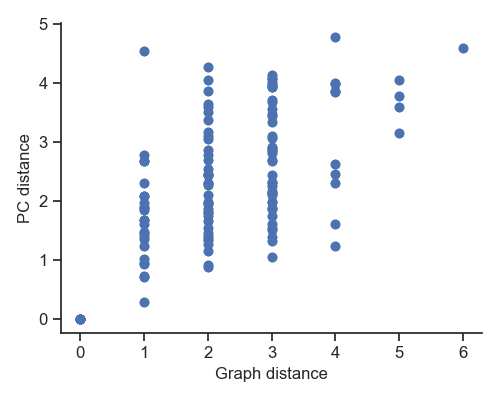

In [133]:
plt.close('all')
fig = plt.figure(figsize=(5,4))
plt.scatter(grid.ravel(),PC_distance.ravel())
plt.xlabel('Graph distance')
plt.ylabel('PC distance')
fig.tight_layout()

<Axes: >

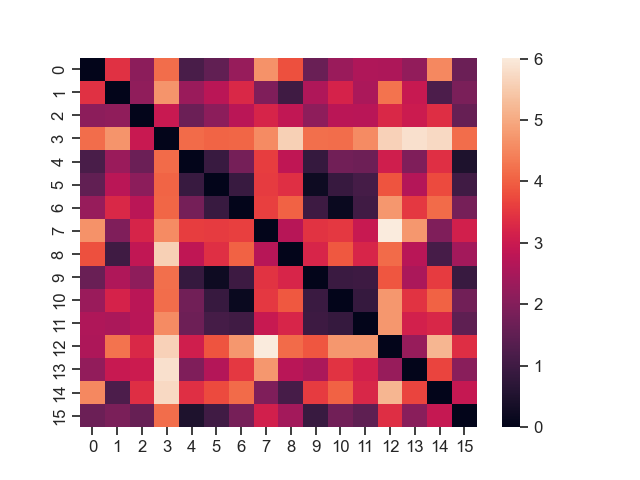

In [101]:
plt.close('all')
sns.heatmap(PC_distance)

In [30]:
nav_target_X = get_mean_FR(choice_df, '(trialerror==0) & ((node==1) | (node==7) | (node==8) | (node==14)) & istarget', 'node')
nav_nottarget_X = get_mean_FR(choice_df, '(trialerror==0) & ((node==1) | (node==7) | (node==8) | (node==14) & ~istarget)', 'node')
flash_X = get_mean_FR(choice_df, 'trialerror==1', 'node')

train_X = np.concatenate([flash_X,nav_target_X,nav_nottarget_X])

pca = PCA(n_components=3)
pca.fit(train_X)

PCA(n_components=3)

In [39]:
targets = [1, 7, 8, 14]
red_X_all = []

for target in targets:
    test_X = get_mean_FR(choice_df, '(trialerror==0) & (target==@target)', 'node')
    red_X = pca.transform(test_X)
    red_X_all.append(red_X)

In [96]:
# target by step 
train_X = []
for step in range(4):
    train_X.append(get_mean_FR(choice_df, 'step==@step & istarget', 'node'))

train_X = np.vstack(train_X)

In [100]:
# target by step 
train_X = []
for step in range(4):
    train_X.append(get_mean_FR(choice_df, 'step==@step & istarget', 'node'))

pca = PCA(n_components=3)
pca.fit(np.vstack(train_X))

red_X_all = []
for step in range(4):
    red_X = pca.transform(train_X[step])
    red_X_all.append(red_X)

In [99]:
# date = '101124'
choice_df['blocktrialnumber']=choice_df.groupby(['Session','block','trial']).cumcount()+1

In [89]:
flash_X1 = get_mean_FR(choice_df, '(trialerror==1) & (blocktrialnumber==1)', 'node')
flash_X2 = get_mean_FR(choice_df, '(trialerror==1) & (blocktrialnumber==2)', 'node')

In [123]:
nav_X1 = get_mean_FR(choice_df, '(trialerror==0) & ((node==1) | (node==7) | (node==8) | (node==14)) & istarget & (blocktrialnumber==3)', 'node')
nav_X2 = get_mean_FR(choice_df, '(trialerror==0) & ((node==1) | (node==7) | (node==8) | (node==14)) & istarget & (blocktrialnumber==4)', 'node')
nav_X3 = get_mean_FR(choice_df, '(trialerror==0) & ((node==1) | (node==7) | (node==8) | (node==14)) & istarget & (blocktrialnumber==5)', 'node')
nav_X4 = get_mean_FR(choice_df, '(trialerror==0) & ((node==1) | (node==7) | (node==8) | (node==14)) & istarget & (blocktrialnumber==6)', 'node')

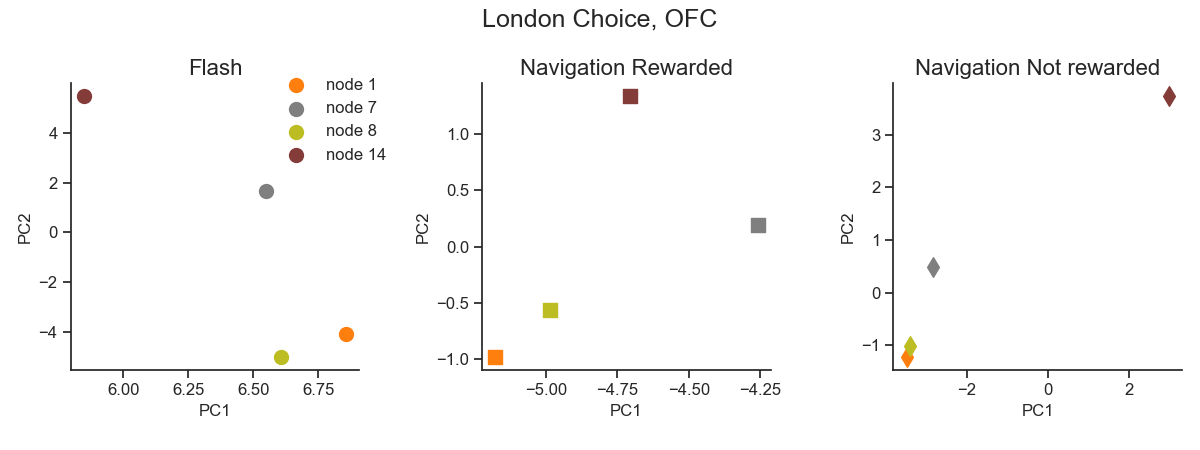

In [148]:
targets = [1, 7, 8, 14]
# red_X_all = [pca.transform(flash_X),pca.transform(nav_target_X),pca.transform(nav_nottarget_X)]
# red_X_all = [pca.transform(flash_X1),pca.transform(flash_X2),pca.transform(nav_X1),pca.transform(nav_X2)]

# for target in targets:
#     test_X = get_mean_FR(choice_df, '(trialerror==0) & (target==@target)', 'istarget')
#     red_X = pca.transform(test_X)
#     red_X_all.append(red_X)

# red_X_all = [pca.transform(nav_X),pca.transform(flash_X)]
markers = ['o','s','d','+']
titles = ['Flash','Navigation Rewarded','Navigation Not rewarded']
# titles = ['Flash 1', 'Flash 2', 'Nav 1', 'Nav 2']
# titles = ['step 0','step 1','step 2','step 3']
# titles = ['Target 1','Target 7','Target 8','Target 14']

fig2, axes = plt.subplots(1, len(red_X_all), figsize=(4*len(red_X_all), 4.5))

for ii in range(len(red_X_all)):
    ax = axes[ii]
    # PC1 vs PC2 (you can change to PC1 vs PC3 if desired)
    for jj, target in enumerate(targets):
        x, y = red_X_all[ii][jj, 0], red_X_all[ii][jj, 1]
        ax.scatter(x, y, color=colors16[target], s=100,marker=markers[ii],label=f"node {target}")
        # ax.text(x-0.4, y+0.1, str(target), fontsize=9, ha="center")
        if ii==0:
            ax.legend(frameon=False,loc=(0.7,0.7))
    
    # ax.set_xlim(-2, 4)
    # ax.set_ylim(-6, 2)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title(titles[ii],fontsize=16)

plt.suptitle("Bart Choice, HPC", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.savefig('Bart HPC target nodes, nav target flash')


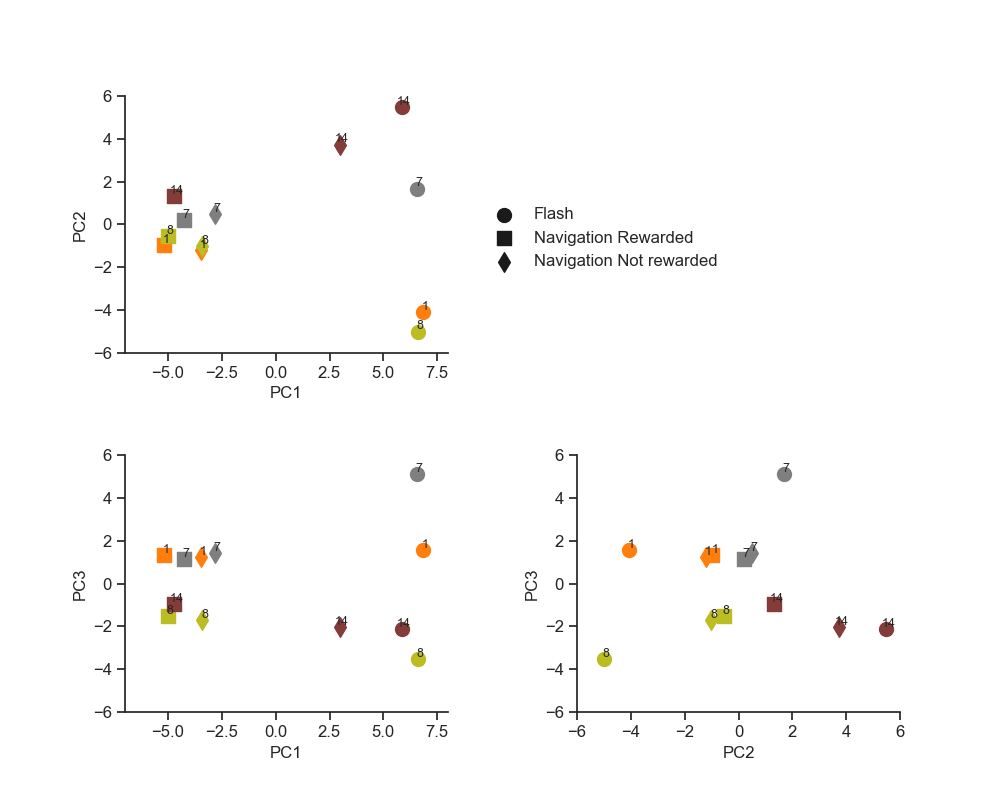

In [156]:
plt.close('all')
fig2, axes = plt.subplots(2, 2, figsize=(10, 8))
markers=['o','s','d','+']

for jj in range(len(red_X_all)):

    reduced_coef = red_X_all[jj]
    
    # PC1 vs PC2
    ax12 = axes[0,0]
    for ii, target in enumerate(targets):
        x, y = reduced_coef[ii, 0], reduced_coef[ii, 1]
        ax12.scatter(x, y, color=colors16[target], s=100,marker=markers[jj])
        ax12.text(x+0.1, y+0.1, str(target), fontsize=9, ha="center")
    ax12.set_xlim(-7,8)
    ax12.set_ylim(-6,6)
    ax12.set_xlabel("PC1")
    ax12.set_ylabel("PC2")
    # ax12.set_title("Projection on PC1-PC2")
    ax12.scatter(-8, 0, color='k', s=100,marker=markers[jj],label=titles[jj])
    ax12.legend(frameon=False, loc=(1.1,0.3))

    # PC1 vs PC3
    ax13 = axes[1,0]
    for ii, target in enumerate(targets):
        x, z = reduced_coef[ii, 0], reduced_coef[ii, 2]
        ax13.scatter(x, z, color=colors16[target], s=100,marker=markers[jj])
        ax13.text(x+0.1, z+0.1, str(target), fontsize=9, ha="center")
    ax13.set_xlabel("PC1")
    ax13.set_ylabel("PC3")
    ax13.set_xlim(-7,8)
    ax13.set_ylim(-6,6)
    # ax13.set_title("Projection on PC1-PC3")
    
    # PC2 vs PC3
    ax23 = axes[1,1]
    for ii, target in enumerate(targets):
        y, z = reduced_coef[ii, 1], reduced_coef[ii, 2]
        ax23.scatter(y, z, color=colors16[target], s=100,marker=markers[jj])
        ax23.text(y+0.1, z+0.1, str(target), fontsize=9, ha="center")
    ax23.set_xlabel("PC2")
    ax23.set_ylabel("PC3")
    ax23.set_xlim(-6,6)
    ax23.set_ylim(-6,6)
    # ax23.set_title("Projection on PC2-PC3")


    axes[0,1].set_visible(False)
    
    plt.subplots_adjust(wspace=0.4,hspace=0.4)
    # plt.suptitle('London Choice, Target=%i' % target)
    plt.savefig('London OFC target, nav target flash')

In [15]:
nav_target_X = get_mean_FR(choice_df, '(trialerror==0) & ((node==1) | (node==7) | (node==8) | (node==14)) & istarget', 'node')
nav_nottarget_X = get_mean_FR(choice_df, '(trialerror==0) & ((node==1) | (node==7) | (node==8) | (node==14) & ~istarget)', 'node')
red_X_all = [pca.transform(nav_target_X),pca.transform(nav_nottarget_X)]

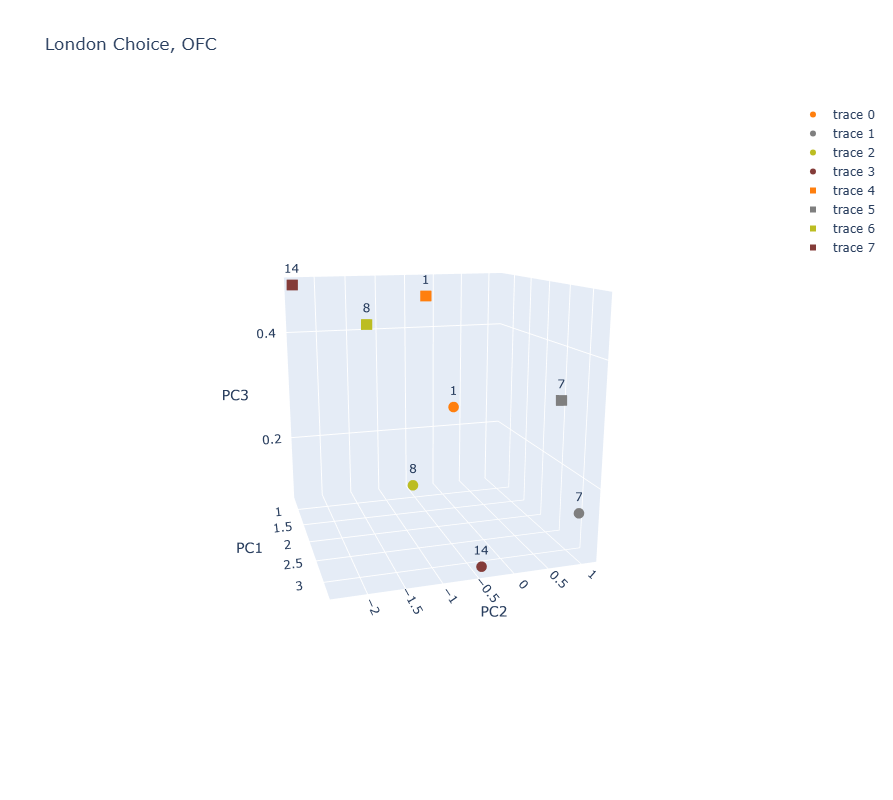

In [19]:
import plotly.graph_objects as go
markers = ['circle','square','diamond','cross']
targets = [1,7,8,14]
fig = go.Figure()

# Loop through jj and targets
for jj in range(len(red_X_all)):
    reduced_coef = red_X_all[jj]

    for ii, target in enumerate(targets):
        x, y, z = reduced_coef[ii, 0], reduced_coef[ii, 1], reduced_coef[ii, 2]

        fig.add_trace(go.Scatter3d(
            x=[x], y=[y], z=[z],
            mode="markers+text",
            marker=dict(size=6, color=colors16[target], symbol=markers[jj]),
            text=[str(target)],
            textposition="top center",
        ))

# Set axes labels and title
fig.update_layout(
    scene=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC3"
    ),
    title="London Choice, OFC",
    width=800,
    height=800
)

# Save to interactive HTML
# fig.write_html("London OFC choice nav target flash.html")

fig.show()



In [105]:
T = create_grid(4,teleports=[[0,15]])
grid = distance_matrix(T)

In [43]:
a=np.zeros(4)
for ii, target in enumerate([1,7,8,14]):
    a[ii]=np.linalg.norm(red_X_all[ii][0,:]-red_X_all[ii][15,:])

In [65]:
freq = choice_df.query('step==0').groupby(['target']).use_tele.mean().values

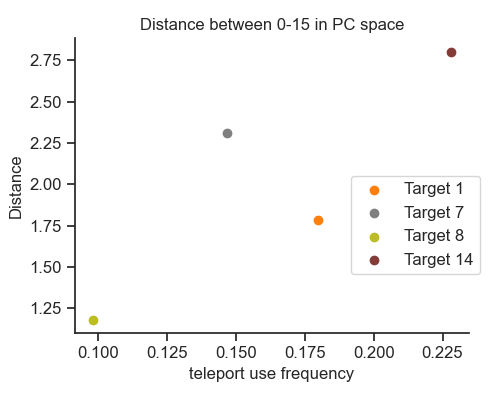

In [87]:
plt.close('all')
fig = plt.figure(figsize=(5,4))
for ii, target in enumerate([1,7,8,14]):
    plt.scatter(freq[ii],a[ii],color=colors16[target],label='Target %i'%target)
plt.legend(loc=(0.7,0.2))
plt.xlabel('teleport use frequency')
plt.ylabel('Distance')
plt.title('Distance between 0-15 in PC space')
fig.tight_layout()

In [281]:
distance_mat = np.zeros((4,4,16,2))

for ii, target in enumerate([1,7,8,14]):
    for jj,ref in enumerate([1,7,8,14]):
        for nn in range(16):
            distance_mat[ii,jj,nn,0] = grid[ref,nn]
            distance_mat[ii,jj,nn,1] = np.linalg.norm(red_X_all[jj][ref,:]-red_X_all[ii][nn,:])

In [283]:
comp = np.zeros((4,2,16))
for ii in range(4):
    comp[ii,0,:] = distance_mat[ii,ii,:,1]
    comp[ii,1,:] = distance_mat[ii,np.arange(4)!=ii,:,1].mean(axis=0)

comp[comp==0]=np.nan

In [295]:
stats.ttest_rel(comp[3,0,:].ravel(),comp[3,1,:].ravel(),nan_policy="omit")

TtestResult(statistic=17.76943983198556, pvalue=5.307948068032356e-11, df=14)

In [303]:
choice_df.groupby(['target','istarget']).count()

Session  start_time  stop_time  trial  step  trialerror  \
target istarget                                                            
1.0    False        2861        2861       2861   2861  2861        2861   
       True         1590        1590       1590   1590  1590        1590   
7.0    False        3238        3238       3238   3238  3238        3238   
       True         1603        1603       1603   1603  1603        1603   
8.0    False        3116        3116       3116   3116  3116        3116   
       True         1581        1581       1581   1581  1581        1581   
14.0   False        2820        2820       2820   2820  2820        2820   
       True         1570        1570       1570   1570  1570        1570   

                 nsteps  start  block  blocktrialnumber  ...  t_on  \
target istarget                                          ...         
1.0    False       2861   2861   2861              2861  ...  2861   
       True        1590   1590   1590              1590  ...  1590   
7.0    False       3238   3238   3238              3238  ...  3238   
       True        1603   1603   1603              1603  ...  1603   
8.0    False       3116   3116   3116              3116  ...  3116   
       True        1581   1581   1581              1581  ...  1581   
14.0   False       2820   2820   2820              2820  ...  2820   
       True        1570   1570   1570              1570  ...  1570   

                 graph_distance  spatial_distance  window_size  nodes    FR  \
target istarget                                                               
1.0    False               2861              2861         2861   2861  2861   
       True                1590              1590         1590   1590  1590   
7.0    False               3238              3238         3238   3238  3238   
       True                1603              1603         1603   1603  1603   
8.0    False               3116              3116         3116   3116  3116   
       True                1581              1581         1581   1581  1581   
14.0   False               2820              2820         2820   2820  2820   
       True                1570              1570         1570   1570  1570   

                 normFR  use_tele  prenode  postnode  
target istarget                                       
1.0    False       2861      2861     2861      2861  
       True        1590      1590     1590      1590  
7.0    False       3238      3238     3238      3238  
       True        1603      1603     1603      1603  
8.0    False       3116      3116     3116      3116  
       True        1581      1581     1581      1581  
14.0   False       2820      2820     2820      2820  
       True        1570      1570     1570      1570  

[8 rows x 22 columns]

Text(0.5, 1.05, 'Distance to target in the PC space')

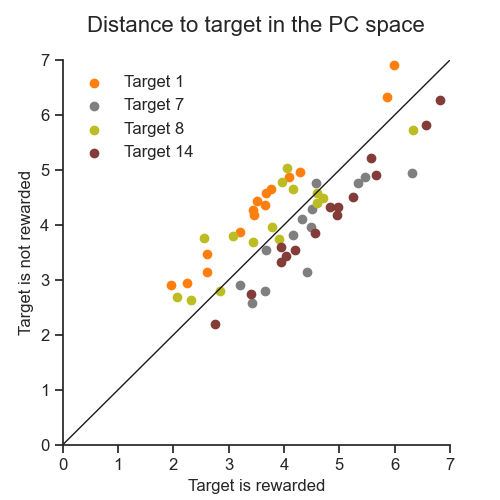

In [287]:
plt.close('all')
plt.figure(figsize=(5,5))
for ii, target in enumerate(targets):
    plt.scatter(comp[ii,0,:],comp[ii,1,:],color=colors16[target],label='Target %i' % target)
plt.plot([0,7],[0,7],'k-')
plt.xlim(0,7)
plt.ylim(0,7)
plt.legend(frameon=False)
plt.xlabel('Target is rewarded')
plt.ylabel('Target is not rewarded')
plt.title('Distance to target in the PC space',fontsize=16,y=1.05)

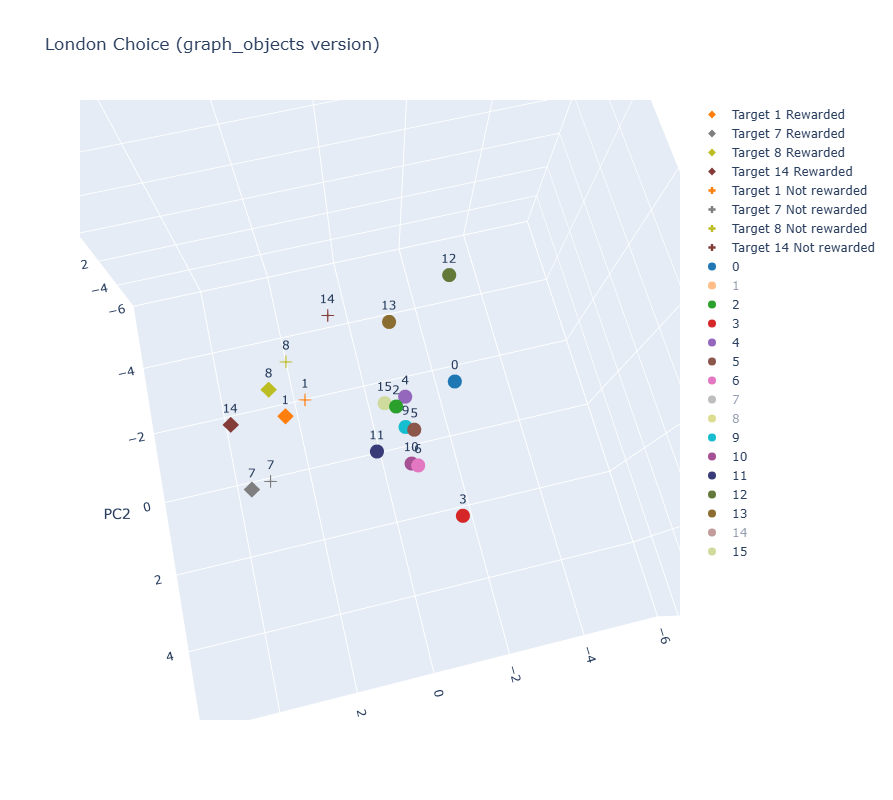

In [35]:
import plotly.graph_objects as go

fig = go.Figure()
# red_X = pca.transform(train_X)
# reduced_coef: shape (n_points, 3)
# targets: class labels (same length as reduced_coef)
# colors16: list/dict of colors indexed by target
# markers: list of marker symbols (e.g. ["circle", "square", "diamond"])

titles = ['Target 1','Target 7','Target 8','Target 14']
markers = ["circle", "square", "diamond","cross"]
targets=[1,7,8,14]
condition=['Rewarded','Not rewarded']


# Loop through jj and targets
for jj in range(len(red_X_all)):
    
    reduced_coef = red_X_all[jj]

    for ii, target in enumerate(targets):
        x, y, z = reduced_coef[ii, 0], reduced_coef[ii, 1], reduced_coef[ii, 2]

        fig.add_trace(go.Scatter3d(
            x=[x], y=[y], z=[z],
            mode="markers+text",
            marker=dict(size=6, color=colors16[target], symbol=markers[jj+2]),
            text=[str(target)],
            textposition="top center",
            name=titles[ii]+' '+condition[jj]
        ))

red_X = pca.transform(train_X)
for ii in range(16):
    # ii=3
    x, y, z = red_X[ii, 0], red_X[ii, 1], red_X[ii, 2]

    fig.add_trace(go.Scatter3d(
        x=[x], y=[y], z=[z],
        mode="markers+text",
        marker=dict(
            size=8,
            color=colors16[ii],   # choose color based on target
            symbol=markers[0]
                # or markers[ii] depending on setup
        ),
        text=[str(ii)],          # show target label
        textposition="top center",
        name=str(ii)             # legend entry
    ))

# Axis titles
fig.update_layout(
    scene=dict(
        xaxis=dict(title="PC1", range=[-6, 6]),
        yaxis=dict(title="PC2", range=[-6, 6]),
        zaxis=dict(title="PC3", range=[-6, 6]),
    ),
    title="London Choice (graph_objects version)",
    width=800,
    height=800
)

# Save as interactive HTML
# fig.write_html("Bart node first step.html")

fig.show()


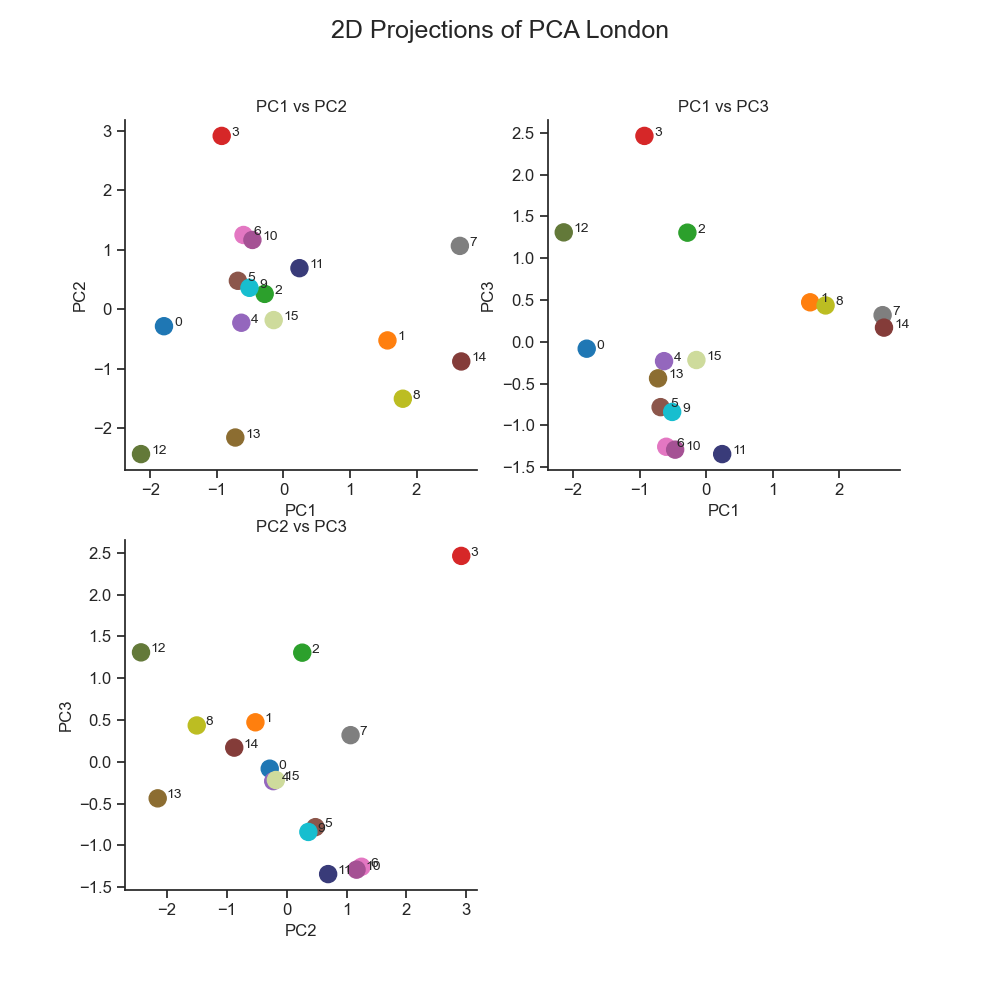

In [77]:
plt.close('all')

# ---- 2D projections ----
fig2d, axes = plt.subplots(2,2,figsize=(10,10))

# PC1 vs PC2
axes[0,0].scatter(red_X[:,0], red_X[:,1], c=colors16, s=150)
for ii in range(16):
    axes[0,0].text(red_X[ii,0]+0.15, red_X[ii,1], str(ii), fontsize=10)
axes[0,0].set_xlabel("PC1")
axes[0,0].set_ylabel("PC2")
axes[0,0].set_title("PC1 vs PC2")

# PC1 vs PC3
axes[0,1].scatter(red_X[:,0], red_X[:,2], c=colors16, s=150)
for ii in range(16):
    axes[0,1].text(red_X[ii,0]+0.15, red_X[ii,2], str(ii), fontsize=10)
axes[0,1].set_xlabel("PC1")
axes[0,1].set_ylabel("PC3")
axes[0,1].set_title("PC1 vs PC3")

# PC2 vs PC3
axes[1,0].scatter(red_X[:,1], red_X[:,2], c=colors16, s=150)
for ii in range(16):
    axes[1,0].text(red_X[ii,1]+0.15, red_X[ii,2], str(ii), fontsize=10)
axes[1,0].set_xlabel("PC2")
axes[1,0].set_ylabel("PC3")
axes[1,0].set_title("PC2 vs PC3")

# Empty subplot (bottom right)
axes[1,1].axis("off")

fig2d.suptitle("2D Projections of PCA London", fontsize=18)
plt.savefig("2D Projections of PCA London")

# plt.tight_layout()


(-0.15000000000000002, 3.15, -3.15, 0.15000000000000002)

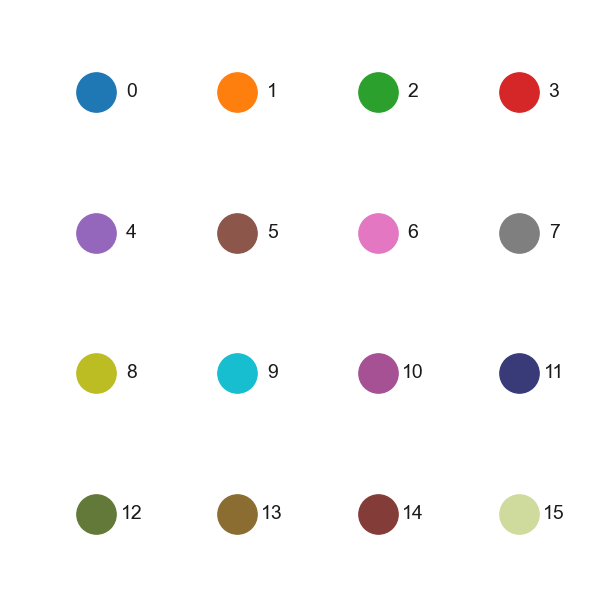

In [29]:
# Right 2D grid
plt.close('all')
plt.figure(figsize=(6,6))
for ii in range(16):
    row, col = divmod(ii, 4)
    plt.scatter(col, -row, color=colors16[ii], s=800, edgecolor=None)
    plt.text(col+0.25, -row, str(ii), ha="center", va="center",
              color="k", fontsize=14)

# plt.xlim(-2, 5)
# plt.ylim(-5, 2)
# plt.xticks(range(4))
# plt.yticks([-0, -1, -2, -3], [0, 1, 2, 3])
# plt.title("Color grid")
plt.axis('equal')
plt.axis('off')


In [37]:
def create_grid(n,barriers=[],teleports=[]):

    # create n*n grid, transition matrix
    T = np.zeros((n*n,n*n))
    block = np.diag(np.ones(n-1), k=1) + np.diag(np.ones(n-1), k=-1)
    
    for c in range(n):
        T[c*n:(c+1)*n,c*n:(c+1)*n] = block
        cols = np.arange(c, n*n, n)  
        row_idx, col_idx = np.meshgrid(cols, cols, indexing='ij')  # shape (4, 4)
        T[row_idx, col_idx] = block

    if len(barriers)>0:
        for barrier in barriers:
            T[barrier[0],barrier[1]]=0
            T[barrier[1],barrier[0]]=0

    if len(teleports)>0:
        for teleport in teleports:
            T[teleport[0],teleport[1]]=1
            T[teleport[1],teleport[0]]=1  
    
    return T


def distance_matrix(T):
    
    # calculate distance 
    n_state = T.shape[0]
    D=np.zeros((n_state,n_state))
    step=0
    connected = np.eye(n_state)
    nsteps = np.eye(n_state)

    if np.sum(T.mean(axis=0)==0)>0:

        D = np.nan    # check if all the nodes are reachable

    else:
    
        while connected.mean()<1:
        
            step=step+1
            nsteps = np.dot(nsteps,T)*(1-connected)
        
            D[nsteps>0]=step
            connected[nsteps>0]=1

    return D